In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas

from collections import defaultdict, Counter

<img src="img/Exercise08.png" width=1000>

# Let's get the posterior $p( a, b | \vec{d} )$

In [4]:
from utilities import flat, truncated_jeffreys

In [83]:
def prior_a(a):
    return truncated_jeffreys(a, lower=0.04, upper=25) / (np.log(25) - np.log(0.04))

prior_a(0)


0.0

In [117]:

def prior_b(b):
    return flat(b, lower=0, upper=7)

In [118]:
def func(x, a, b):
    return np.sin(a*x + b)

In [119]:
data = list(zip(
    np.array([2.5, 7, 8.5]),
    np.array([0.1, 0.35, 1.0])
))
data[:1]

[(2.5, 0.1)]

In [120]:
d1 = data[:1]
d1

[(2.5, 0.1)]

In [140]:
def likelihood(a, b, data, sigma=0.2, f=func):
    """p(data | a, b)"""
    exponent = - 0.5 * np.sum([
        (y - f(x, a, b))**2 for x, y in data
    ], axis=0) / sigma**2

    return np.exp(exponent) / (sigma * np.sqrt(2*np.pi))

likelihood(1, 1, data=data[:1])

0.1573048557008377

In [141]:
def posterior_a_b(a, b, data):
    p = likelihood(a, b, data=data, sigma=0.2) * prior_a(a) * prior_b(b)
    return p

posterior_a_b(1,2, data=data[:1])

2.2027381205413783e-08

/var/folders/y5/v1z7p_cs5r52n2kw2rl1bymc0000gp/T/ipykernel_35337/947706923.py:9: RuntimeWarning: divide by zero encountered in log
  aa, bb, np.log(p)


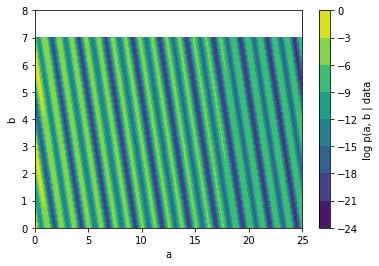

In [142]:
aa, bb = np.meshgrid(
    np.linspace(0, 25, 1000),
    np.linspace(0, 8, 1000)
)

p = posterior_a_b(aa, bb, data=d1)

plt.contourf(
    aa, bb, np.log(p)
)

plt.xlabel("a")
plt.ylabel("b")
cbar = plt.colorbar()
cbar.set_label("log p(a, b | data")

In [143]:
np.max(p)

0.884367928379279

## Norm the posterior

In [144]:
N = 10000
aa, bb = np.meshgrid(
    np.linspace(0, 25, N),
    np.linspace(0, 8, N)
)

p = posterior_a_b(aa, bb, data=d1)

np.sum(p) * np.mean(np.diff(aa[0, :])) * np.mean(np.diff(bb[:, 0]))


0.3258419057991915

In [145]:
Z_posterior = scipy.integrate.dblquad(
    lambda y, x: posterior_a_b(a=x, b=y, data=d1),
    0, 25, # limits for a
    0, 7, # limits for b
)[0]
Z_posterior

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


0.3328325804909829

In [146]:
def posterior_a_b_normed(a, b, data):
    return posterior_a_b(a, b, data=data) / Z_posterior

scipy.integrate.dblquad(
    lambda y, x: posterior_a_b_normed(x, y, data=d1),
    0, 25, # limits for a
    0, 7, # limits for b
)

(1.0000214731382175, 0.25458565164560926)

# Sample the posterior (via rejection method)

In [147]:
sigma = 0.2

# max of prior a: 1/x, where x=lower boundary --> 1/0.04 (* normalisation)
# max of prior a: 1/7

# max of posterior:
1/(sigma * np.sqrt(2 * np.pi)) * (1/7) * (1/0.04) * (1/(np.log(25) - np.log(0.04))) / Z_posterior

3.324772914259435

In [148]:
# without norms
1/(sigma * np.sqrt(2 * np.pi)) * (1/7) * (1/0.04) 

7.123969292882726

In [149]:
def envelope(a, b, value=8):
    """Estimate for max of posterior see above --> value"""

    # check the boundaries
    L = prior_a(a) * prior_b(b) != 0

    r = np.zeros_like(a)
    r[L] = value
    return r


Text(0, 0.5, 'b')

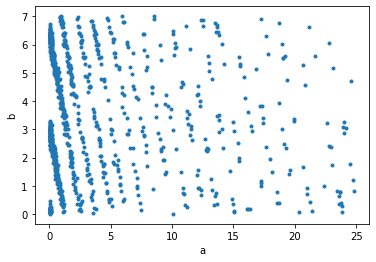

In [153]:
def inverse_sampling_of_a_b(N, blocksize=None, data=d1):

    if blocksize is None:
        blocksize = N

    sampled_values_a = []
    sampled_values_b = []
    
    while len(sampled_values_a) < N:

        u = np.random.rand(blocksize)
        
        y = (np.random.rand(blocksize, 2) * np.array([30, 8])).transpose()
        
        
        #is_accepted = u > (prior_function(y) / envelope_function(y))
        is_accepted = (u * envelope(*y)) < posterior_a_b_normed(*y, data=data)
        
        sampled_values_a += list(y[0, is_accepted])
        sampled_values_b += list(y[1, is_accepted])

        #break
    return np.asarray(sampled_values_a[:N]), np.asarray(sampled_values_b[:N])


samples_a, samples_b = inverse_sampling_of_a_b(
    N=1000,
    #blocksize=10000,
    data=data[:1]
)

plt.plot(samples_a, samples_b, ".")
plt.xlabel("a")
plt.ylabel("b")


In [138]:
samples_a.shape

(1000,)

In [139]:
(np.log(25) - np.log(0.04))

6.437751649736401